### Analytics utils sandbox

Goal: Create function **discretize** to convert unioned disagreement annotation timestamps for each episode into y (labels discretized based on sliding window) and also create timestamps (start, end) corresponding to each sliding window

How does the proportion of segments containing disagreement change with the threshold of overlap required for disagreement?

In [1]:
import numpy as np
import librosa
import os, sys
import pickle
import matplotlib.pyplot as plt
import pickle

parent_directory = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(parent_directory)
from common.annotation_utils import get_union, tp

In [2]:
episode_id = '0TkGYYIPwRqx8xzP0XGvRG'
unioned_annotation_dict_file = open('../../audio_annotation/outputs/unioned_annotations_dict.pkl', 'rb')
unioned_annotation_dict = pickle.load(unioned_annotation_dict_file)

def discretize(episode_id, 
               unioned_annotation_dict, 
               audio_filename,
               segment_length = 2.5, hop_length = 0.5, overlap_thresh = 0.2, verbose = False):
    audio_duration = librosa.get_duration(filename = audio_filename)
    segments = np.arange(0, audio_duration - segment_length, hop_length)
    disagreement_annotations = unioned_annotation_dict[episode_id]
    if verbose:
        print(f"Audio duration (secs): {audio_duration:.3f}")
        print(f"Audio duration (mins): {audio_duration/60:.3f}")
        print(disagreement_annotations)

    times = []; y = []
    for i in range(len(segments)):
        start_time = segments[i]
        end_time = start_time + segment_length
        t = tp(start_time, end_time)
        times.append(t)
        y.append(1*any([t.overlap(d) >= overlap_thresh for d in disagreement_annotations]))
    return times, y

In [3]:
times, y = discretize(episode_id, 
                      unioned_annotation_dict,
                      '../../data/audio/'+episode_id+'.ogg',
                      overlap_thresh = 0.2, verbose = True)

Audio duration (secs): 1507.183
Audio duration (mins): 25.120
[(75.42,77.62), (359.17,365.12), (372.02,376.82), (416.57,420.02), (423.07,428.87), (429.17,439.32), (575.77,579.27), (712.07,714.22), (723.47,726.12), (731.02,736.87)]


In [4]:
times[-10:]

[(1500.00,1502.50),
 (1500.50,1503.00),
 (1501.00,1503.50),
 (1501.50,1504.00),
 (1502.00,1504.50),
 (1502.50,1505.00),
 (1503.00,1505.50),
 (1503.50,1506.00),
 (1504.00,1506.50),
 (1504.50,1507.00)]

In [5]:
y[-10:]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [6]:
threshold_grid = np.linspace(0.01, 1, 91)
num_labeled = []

for th in threshold_grid:
    times, y = discretize(episode_id, unioned_annotation_dict, 
                          '../../data/audio/'+episode_id+'.ogg',
                          overlap_thresh = th)
    num_labeled.append(np.sum(np.array(y))/len(times))

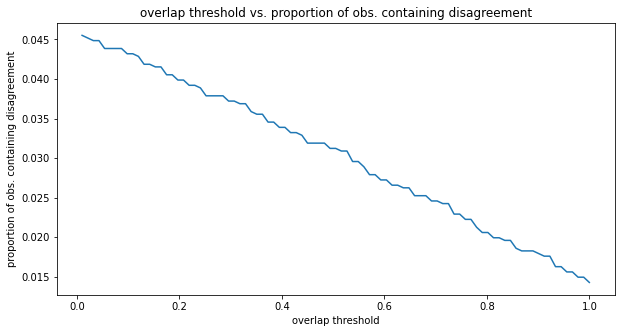

In [7]:
plt.figure(figsize = (10,5))
plt.plot(threshold_grid, num_labeled)
plt.xlabel('overlap threshold')
plt.ylabel('proportion of obs. containing disagreement')
plt.title('overlap threshold vs. proportion of obs. containing disagreement');